# Analiza danych przestrzennych - ćwiczenia laboratoryjne 2022/2023

Ten notatnik zalicza się do grupy zestawów zadań, na podstawie których odbywa się zaliczenie ćwiczeń i podlega zwrotowi do oceny w ustalonym na zajęciach terminie.

Uwagi ogólne:
- Podczas wykonywania zadań należy korzystać wyłącznie z pakietów zaimportowanych na początku notatnika oraz z pakietów wchodzących w skład standardowej biblioteki Pythona, które można zaimportować samodzielnie we wskazanej komórce.
- Swoje rozwiązania należy wprowadzać wyłącznie w miejce następujących fragmentów kodu:<br/> ` # YOUR CODE HERE`<br/> ` raise NotImplementedError()`<br/> Nie należy w żaden sposób modyfikować pozostałych fragmentów kodu oraz elementów notatnika, w szczególności dodawać lub usuwać komórek oraz zmieniać nazwy pliku.
- Jeżeli zestaw zadań wymaga skorzystania z funkcji przygotowanych w ramach wcześniejszych zestawów zadań należy je umieścić we wskazanej komórce.
- Wszystkie wykresy powinny być wykonane w jednolitym, przejrzystym i czytelnym stylu, mieć nadane tytuły, opisane osie oraz odpowiednio dobrany rozmiar, wielkość punktów i grubość linii. Proporcje osi wykresów przedstawiających rozkłady punktów powinny być dobrane tak, aby wykresy odzwierciedlały rzeczywisty rozkład punktów w przestrzeni.
- Zadania, które powodują wyświetlenie komunikatu o błędzie przerywającym wykonywanie kodu nie podlegają ocenie.

Przed odesłaniem zestawu zadań do oceny proszę uzupełnić komórkę z danymi autorów rozwiązania (`NAME` - nazwa grupy, `COLLABORATORS` - imiona, nazwiska i numery indeksów członków grupy) oraz upewnić się, że notatnik działa zgodnie z oczekiwaniami. W tym celu należy skorzystać z opcji **Restart Kernel and Run All Cells...** dostępnej na górnej belce notatnika pod symbolem $\blacktriangleright\blacktriangleright$. 

In [1]:
COLLABORATORS = "Nawara Joanna, Śliwa Karol, Kopeć Marta"

---

## Zestaw zadań 6: Klasteryzacja, agregacja i autokorelacja danych

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ["OMP_NUM_THREADS"] = '1'
from sklearn.cluster import KMeans

In [3]:
# Miejsce do importu pakietów wchodzących w skład standardowej biblioteki Pythona oraz ustawienie opcji wykorzystywanych pakietów
sns.set() 
sns.set_theme(style="whitegrid")

In [5]:
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import examples

### Przygotowanie danych
Wczytaj dane zawarte w plikach CSV załączonych do zestawu zadań.

In [31]:
points = pd.read_csv("points_1.csv")
points_2 = pd.read_csv("points_2.csv")
points_3 = pd.read_csv("points_3.csv")

### Zadanie 1: Klasteryzacja metodą k-średnich (11 pkt)

Przygotuj funkcję `k_means_elbow_curve_test()`, która będzie wykonywała klasteryzację danych dla ustalonego zakresu liczby klastrów oraz obliczała dane niezbędne do wykreślenia wykresu typu elbow curve, na podstawie którego można podjąć decyzję na temat optymalnej liczby klastrów.

Następnie wykorzystaj przygotowaną funkcję do podzielenia na optymalną liczbę klastrów rozkładu punktów z pliku points_1.csv. 

Przedstaw wyniki analizy graficznie w postaci wykresu liniowego (elbow curve) oraz rozkładu punktów podzielonego na optymalną liczbę klastrów. Zestaw wyniki na pojedynczej figurze (siatka wykresów 1x2).

#### a) Przygotowanie funkcji

In [7]:
def k_means_elbow_curve_test(points, number_of_clusters):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    number_of_clusters: list
        Lista określająca zakres testowanej liczby klastrów.
        Przykład: [1, 5]   

    Returns
    -------
    clusters: DataFrame
        Tablica zbierająca wyniki klasteryzacji w następujących kolumnach:
        - "X" - współrzędne X punktów,
        - "Y" - współrzedne Y punktów,
        - kolejne kolumny (ich liczba zależy od liczby testowanych liczebności klastrów) opisane są jako liczba klastrów,
        np. "1", "2", itd. i zawierają numery klastrów, do których zostały przyporządkowane konkretne punkty.
    elbow_curve: DataFrame
        Tablica zbierająca dane niebędne do wykonania wykresu elbow curve w dwóch kolumnach:
        - "N" - liczba klastrów,
        - "D(N)" - średnia odległość punktu od centrum klastra, do którego jest przypisany.
    """
    
    clusters = {'X': points.X, 'Y': points.Y}
    clusters = pd.DataFrame(clusters)
    distortions = []
    
    for i in range(number_of_clusters[0], number_of_clusters[1]+1):
        kmeans = KMeans(i).fit(points)
        clusters[i] = kmeans.labels_
        distortions.append(sum(np.min(sp.spatial.distance.cdist(points, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / points.shape[0])
    elbow_curve = pd.DataFrame({"N": np.arange(number_of_clusters[0], number_of_clusters[1]+1, 1), "D(N)": distortions})
    return clusters, elbow_curve    

#### b) Wygenerowanie danych

In [8]:
clusters, elbow_curve = k_means_elbow_curve_test(points, [1,5])

#### c) Wizualizacja

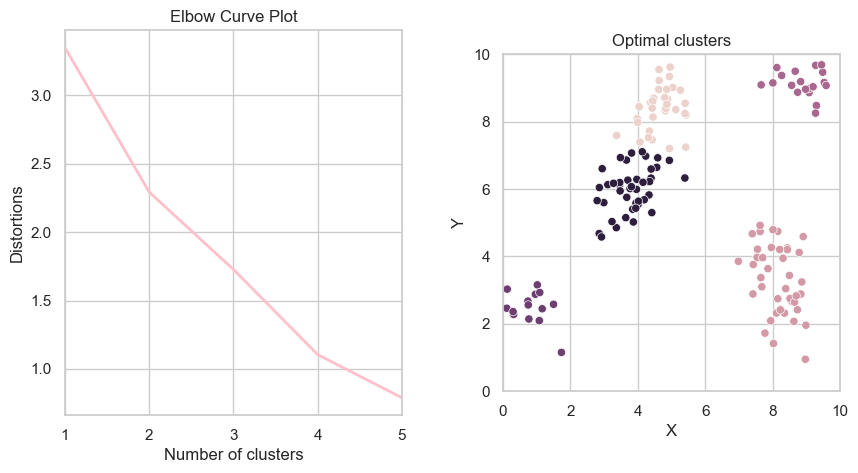

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(data = elbow_curve, x="N", y="D(N)", ax=ax[0], color='pink', linewidth=2)
ax[0].set_title("Elbow Curve Plot")
ax[0].set_xlabel("Number of clusters")
ax[0].set_ylabel("Distortions")
ax[0].set_xlim([1,5])

sns.scatterplot(data = clusters, x="X", y="Y", hue=clusters[5], ax=ax[1], legend=False)
ax[1].set_title("Optimal clusters")
ax[1].set_xlabel("X")
ax[1].set_aspect("equal")
ax[1].set_ylabel("Y")
ax[1].set_xlim([0,10])
ax[1].set_ylim([0,10])

plt.subplots_adjust(wspace = 0.3)
plt.show()

### Zadanie 2: Agregacja danych na siatce prostokątnej (6 pkt)

Przygotuj funkcję `agregate_on_rectangles()`, która będzie zliczać punkty w obrębie prostokątnych podobszarów.

Następnie wykorzystaj przygotowaną funkcję do zagregowania rozkładów punktów z plików points_2.csv i points_3.csv. Ustaw podział obszaru na 40 podobszarów wzdłuż osi $x$ i 20 podobszarów wzdłuż osi $y$.

Przedstaw wyniki analizy graficznie w postaci histogramów dwuwymiarowych z nałożonymi na nie rozkładami punktów. Zestaw wyniki na pojedynczej figurze (siatka wykresów 1x2).

#### a) Przygotowanie funkcji

In [10]:
def agregate_on_rectangles(points, bins, x_lim, y_lim):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    bins: list
        Lista określająca liczbę podobszarów w poziomie i pionie.
        Przykład: [10, 10]
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   

    Returns
    -------
    binned_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z liczbą punków przypisanych do każdego z podobszarów.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]
    """
    H, xedge, yedge = np.histogram2d(x=points["X"], y=points["Y"], bins=bins, range=[x_lim, y_lim])
    kk = [xedge, yedge, H.transpose()]
    return kk
    

#### b) Wygenerowanie danych

In [30]:
# YOUR CODE HERE
bins = [40, 20]
x_lim = [0,20]
y_lim = [0,10]

z2 = agregate_on_rectangles(points_2, bins, x_lim, y_lim)
z3 = agregate_on_rectangles(points_3, bins, x_lim, y_lim)

#### c) Wizualizacja

(41,)


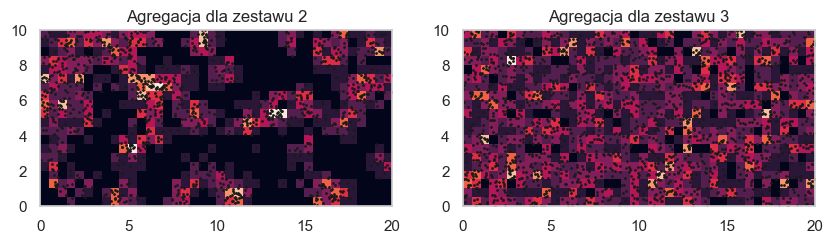

In [13]:
print(z2[0].shape)

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].grid(False)
ax[0].pcolormesh(z2[0], z2[1], z2[2])
ax[0].scatter(points_2.X, points_2.Y, s = 1, c='k')
ax[0].set_title("Agregacja dla zestawu 2")
ax[0].set_aspect('equal')

ax[1].grid(False)
ax[1].pcolormesh(z3[0], z3[1], z3[2])
ax[1].scatter(points_3.X, points_3.Y, s = 1, c='k')
ax[1].set_title("Agregacja dla zestawu 3")
ax[1].set_aspect('equal')

plt.show()

### Zadanie 3: Tablica sąsiedztwa (11 pkt)

Przygotuj funkcję `spatial_weights()`, która będzie przygotowywać tablicę sąsiedztwa podobszarów.

Schemat generowania tablicy sąsiedztwa:

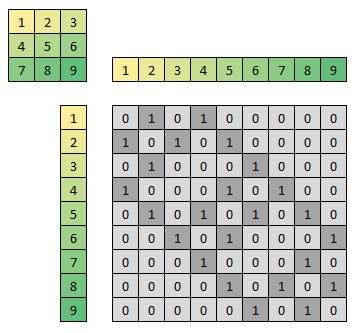

Następnie wykorzystaj przygotowaną funkcję do wykonania tablic sąsiedztwa zagregowanych danych z zadania 2.

Przedstaw wyniki analizy graficznie za pomocą wykresów heatmap. Zestaw wyniki na pojedynczej figurze (siatka wykresów 1x2).

#### a) Przygotowanie funkcji

In [14]:
 def getNeighbors(i, j, m, n):
    nL = []
    if i > 0:
        nL.append([i-1,j])
    if i+1 < m:
        nL.append([i+1,j])
    if j > 0:
        nL.append([i,j-1])
    if j+1 < n:
        nL.append([i,j+1])
    return nL

def spatial_weights(bin_counts):
    """
    Parameters
    -------
    bin_counts: array
        Macierz 2D z liczbą punków przypisanych do każdego z podobszarów.

    Returns
    -------
    w: array
        Macierz 2D zawierająca wagi przestrzenne.
    """    
    # YOUR CODE HERE
    neighbors=[]
    maxX=len(bin_counts[0])
    maxY=len(bin_counts)
    spatialWeight=np.zeros((maxX*maxY, maxX*maxY))
    
    for j in range(maxY):
        for i in range(maxX):
            neighbors.append(getNeighbors(i,j,maxX, maxY))
    
    for i in range(maxX*maxY):
        l=neighbors[i]
        for n in l:
            spatialWeight[i, n[1]*maxX+n[0]]=1
    return spatialWeight    

#### b) Wygenerowanie danych

In [16]:
z2 = agregate_on_rectangles(points_2, bins, x_lim, y_lim)
z3 = agregate_on_rectangles(points_3, bins, x_lim, y_lim)

binCounts2=z2[2]
binCounts3=z3[2]

sw2=spatial_weights(binCounts2)
sw3=spatial_weights(binCounts3)

#### c) Wizualizacja

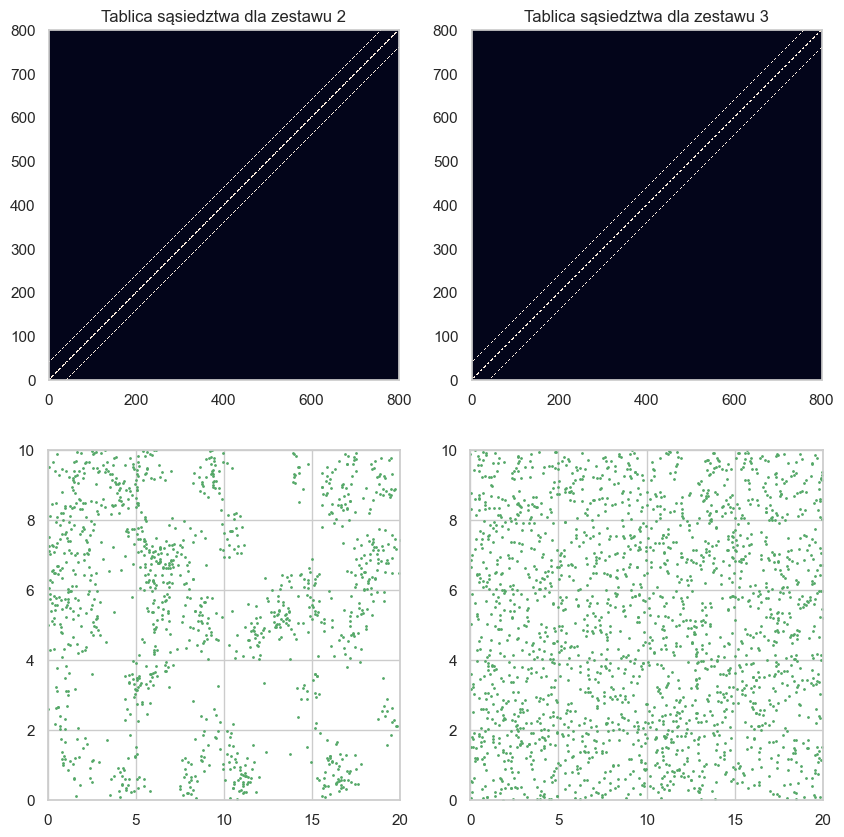

In [17]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].grid(False)
ax[0,0].pcolormesh(sw2)
ax[1,0].scatter(points_2.X, points_2.Y, s = 1, c='g')
ax[1,0].set_xlim([0,20])
ax[1,0].set_ylim([0,10])
ax[0,0].set_title("Tablica sąsiedztwa dla zestawu 2")
ax[0,0].set_aspect('equal')

ax[0,1].grid(False)
ax[0,1].pcolormesh(sw3)
ax[1,1].scatter(points_3.X, points_3.Y, s = 1, c='g')
ax[1,1].set_xlim([0,20])
ax[1,1].set_ylim([0,10])
ax[0,1].set_title("Tablica sąsiedztwa dla zestawu 3")
ax[0,1].set_aspect('equal')

plt.show()

### Zadanie 4: Opóźnienie przestrzenne (11 pkt)

Przygotuj funkcję `spatial_lag()`, która będzie przygotowywać tablicę wartości opóźnienia przestrzennego.

Następnie wykorzystaj przygotowaną funkcję do wyznaczania tablic opóźnienia przestrzennego zagregowanych danych z zadania 2.

Przedstaw wyniki analizy graficznie w postaci histogramów dwuwymiarowych zestawionych z danymi zagregowanymi na podstawie których zostały one wykonane. Zestaw wyniki na pojedynczej figurze (siatka wykresów 2x2). Umieść zagreowane dane w górnym wierszu, a opóźnienie przestrzenne w dolnym wierszu figury.

Algorytm postępowania:
1) Spłaszczamy macierz zliczeń w podobszarach.
2) Obliczamy poszczególne wartości tablicy opóźnienia przestrzennego zgodnie ze wzorem: <br/>
$ LC_{i} = \frac {\sum_j w_{ij} \cdot X_j} {\sum_j w_{ij}}$  <br/>
gdzie: $w$ - macierz sąsiedztwa, $X$ - spłaszczona macierz zliczeń w podobszarach. 
3) Konwertujemy tablicę opóźnienia przestrzennego do tych samych wymiarów jakie miała wejściowa macierz zliczeń w podobszarach.

#### a) Przygotowanie funkcji

In [18]:
def spatial_lag(binned_data):
    """
    Parameters
    -------
    binned_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z liczbą punków przypisanych do każdego z podobszarów.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]

    Returns
    -------
    lagged_data: list
        Lista zawierająca trzy macierze:0
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z wyliczonymi wartościami opóźnienia przestrzennego.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]
    """    
    # YOUR CODE HERE
    lagged_list=[binned_data[0], binned_data[1] ]
    binned_data=binned_data[2]
    x,y=len(binned_data[0]),len(binned_data)
    w=spatial_weights(binned_data)
    X=np.array(binned_data).flatten() #binned_data[2].flatten()
    lc=[]
    
    
    for i in range(len(w)):
        wSum=sum(w[i])
        wxSum=0
        for j in range(len(w[i])):
            wxSum+=w[i,j]*X[j]
        lc.append(wxSum/wSum)
    lc=np.reshape(lc,(y,x))
    lagged_list.append(lc)
    #print(len(lagged_list), len(lagged_list[2][0]))
    return lagged_list

#### b) Wygenerowanie danych

In [29]:
sl2=spatial_lag(z2)
sl3=spatial_lag(z3)

#### c) Wizualizacja

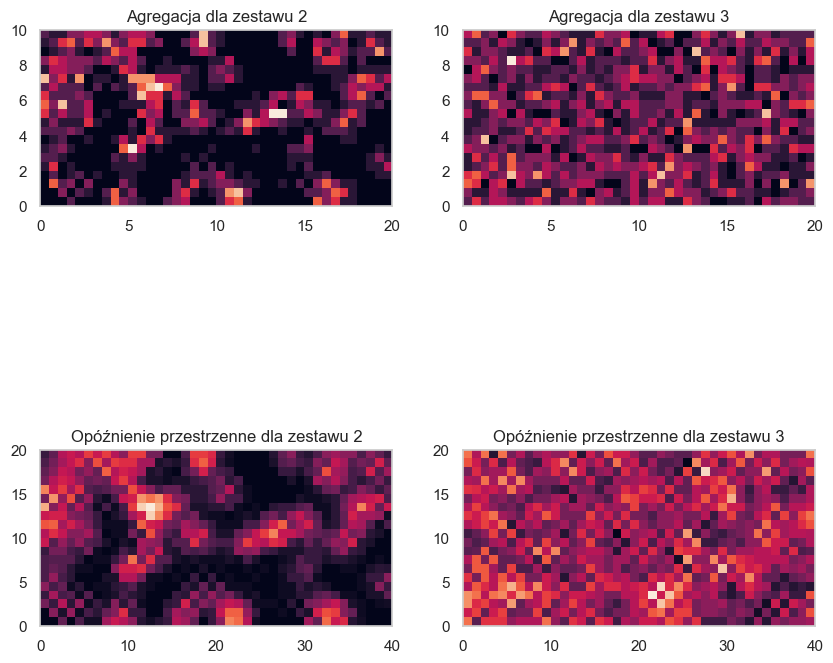

In [21]:
# YOUR CODE HERE
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].grid(False)
ax[0,0].set_title("Agregacja dla zestawu 2")
ax[0,0].pcolormesh(z2[0], z2[1], z2[2])
ax[0,0].set_aspect('equal')

ax[1,0].grid(False)
ax[1,0].set_title('Opóźnienie przestrzenne dla zestawu 2')
ax[1,0].pcolormesh(sl2[2])
ax[1,0].set_aspect('equal')

ax[0,1].grid(False)
ax[0,1].pcolormesh(z3[0], z3[1], z3[2])
ax[0,1].set_title("Agregacja dla zestawu 3")
ax[0,1].set_aspect('equal')

ax[1,1].grid(False)
ax[1,1].set_title('Opóźnienie przestrzenne dla zestawu 3')
ax[1,1].pcolormesh(sl3[2])
ax[1,1].set_aspect('equal')


plt.show()

### Zadanie 5: Wykres Morana (11 pkt)

Przygotuj funckję `moran_plot_data()`, która będzie przygotowywać dane niezbędne do wykonania wykresu Morana. Wykres Morana to zestawienie wartości z macierzy zliczeń ustandaryzowanych poprzez odjęcie od nich ich wartości średniej (oś x) z wartościami z macierzy opóźnienia przestrzennego ustandaryzowanych poprzez odjęcie od nich ich wartości średniej (oś y) z nałożoną na nie prostą regresji.

Następnie wykorzystaj przygotowaną funkcję do przygotowanie danych do wykonania wykresu Morana zagregowanych danych z zadania 2. 

Przedstaw wyniki analizy graficznie w postaci wykresów Morana zestawionych z danymi zagregowanymi na podstawie których zostały wykonane przedstawionymi w postaci histogramów dwuwymiarowych z nałożonymi na nie rozkładami punktów. Zestaw wyniki na pojedynczej figurze (siatka wykresów 2x2). Umieść zagreowane dane w górnym wierszu, a wykresy Morana w dolnym wierszu figury.

#### a) Przygotowanie funkcji

In [23]:
def moran_plot_data(bin_counts, lagged_counts):
    """
    Parameters
    -------
    bin_counts: array
        Macierz 2D z liczbą punków przypisanych do każdego z podobszarów.
    lagged_counts: array
        Macierz 2D z wartościami opóźnienia przestrzennego przypisanego do każdego z podobszarów.

    Returns
    -------
    moran_plot_data: DataFrame
        Tablica zawierająca dwie kolumny danych niebędnych do wykonania wykresu Morana:
        - "AG_STD" - ustandarywowane dane zagregowane,
        - "SL_STD" - ustandarywzowane wartości opóźnienia przestrzennego.
    """ 
    AG_STD = bin_counts.flatten() - np.mean(bin_counts)
    SL_STD = lagged_counts.flatten() - np.mean(lagged_counts)
    
    return pd.DataFrame({"AG_STD": AG_STD, "SL_STD": SL_STD})

#### b) Wygenerowanie danych

In [28]:
bc_2 = z2[2]
bc_3 = z3[2]
lc_2 = sl2[2]
lc_3 = sl3[2]
moran_2 = moran_plot_data(bc_2, lc_2)
moran_3 = moran_plot_data(bc_3, lc_3)


#### c) Wizualizacja

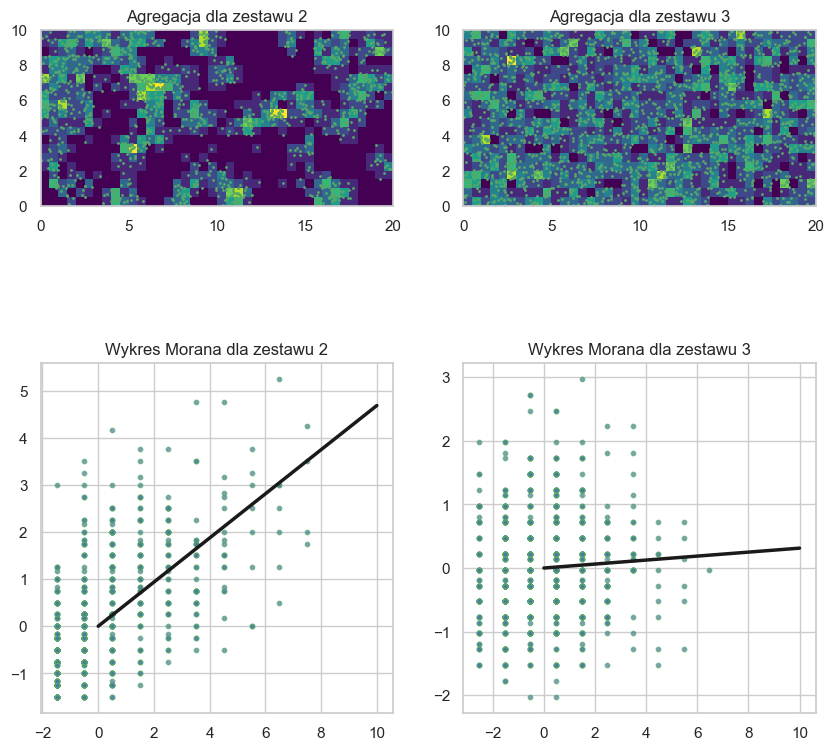

In [27]:
# YOUR CODE HERE
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].grid(False)
ax[0,0].set_title("Agregacja dla zestawu 2")
ax[0,0].pcolormesh(z2[0], z2[1], z2[2])
ax[0,0].scatter(points_2.X, points_2.Y, s = 1, c='g')
ax[0,0].set_aspect('equal')

ax[0,1].grid(False)
ax[0,1].set_title("Agregacja dla zestawu 3")
ax[0,1].pcolormesh(z3[0], z3[1], z3[2])
ax[0,1].scatter(points_3.X, points_3.Y, s = 1, c='g')
ax[0,1].set_aspect('equal')


ax[1,0].set_title('Wykres Morana dla zestawu 2')
#sns.regplot(x="AG_STD", y="SL_STD", data=moran_2, ci=None)
ax[1,0].scatter(moran_2['AG_STD'], moran_2['SL_STD'], s=10, alpha=0.7, edgecolors="g")
b, a = np.polyfit(moran_2['AG_STD'], moran_2['SL_STD'], deg=1)
xseq = np.linspace(0, 10, num=1000)
ax[1,0].plot(xseq, a + b * xseq, color="k", lw=2.5);


ax[1,1].set_title('Wykres Morana dla zestawu 3')
ax[1,1].scatter(moran_3['AG_STD'], moran_3['SL_STD'], s=10, alpha=0.7, edgecolors="g")
b, a = np.polyfit(moran_3['AG_STD'], moran_3['SL_STD'], deg=1)
xseq = np.linspace(0, 10, num=1000)
ax[1,1].plot(xseq, a + b * xseq, color="k", lw=2.5);
